# From terminal:
conda create -n exp-tracking-env python=3.9 #create new environment for the project

conda activate exp-tracking-env #activate the created environment

ipython kernel install --user --name=env-name # Register the kernel spec with Jupyter 
#Now new-env will be displayed in your list of kernels (no need to restart Jupyter Notebook — just reload the page in your browser) 
#Kernel -> Change kernel -> env-name

!pip install -r requirements.txt #install the packages in the requirements file.

deactivate #to deactivate environment at the end

mlflow ui --backend-store-uri sqlite:///mlflow.db #launch mlflow with backend configurations


In [17]:
!python -V

Python 3.9.16


In [2]:
!pip install pyarrow

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [20]:
import pickle

In [21]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/mlops_zoomcamp/notebooks/02- Experiment Tracking/mlruns/1', creation_time=1685290772018, experiment_id='1', last_update_time=1685290772018, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
import os 
os.getcwd()

'/home/mlops_zoomcamp/notebooks/02- Experiment Tracking'

In [5]:
df = pd.read_parquet('/home/mlops_zoomcamp/notebooks/data/green_tripdata_2021-01.parquet')

df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

df['duration']=df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
df= df[((df.duration>=1) &(df.duration<=60))]

categorical=['PULocationID', 'DOLocationID']

df[categorical]=df[categorical].astype(str)

In [8]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [12]:
df=df[df.trip_type ==2]

/home/mlops_zoomcamp/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

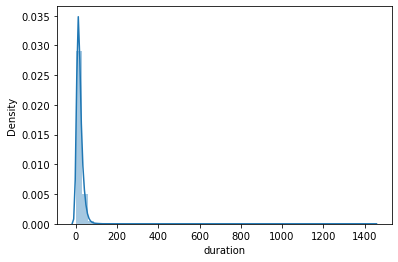

In [34]:
sns.distplot(df.duration)

In [35]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [9]:
df= df[((df.duration>=1) &(df.duration<=60))]

In [18]:
categorical=['PULocationID', 'DOLocationID']
numerical=['trip_distance']

In [39]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [10]:
df[categorical]=df[categorical].astype(str)

In [20]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [22]:
def read_df(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration']=df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    df= df[((df.duration>=1) &(df.duration<=60))]

    categorical=['PULocationID', 'DOLocationID']

    df[categorical]=df[categorical].astype(str)
    return df

In [23]:
filename_train ='/home/mlops_zoomcamp/notebooks/data/green_tripdata_2021-01.parquet'
filename_val = '/home/mlops_zoomcamp/notebooks/data/green_tripdata_2021-02.parquet'
df_train = read_df(filename_train)
df_val = read_df(filename_val)

In [24]:
len(df_train), len(df_val)

(73908, 61921)

In [25]:
df_train['PU_DO'] = df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID']+'_'+df_val['DOLocationID']


In [26]:
dv = DictVectorizer()

categorical= ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical=['trip_distance']

train_dicts = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [12]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

In [21]:
with open ('/home/mlops_zoomcamp/notebooks/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [22]:
la = Lasso(alpha = 0.001)
la.fit(X_train,y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [45]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [23]:
y_train = df['duration'].values

In [24]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [25]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_2903/1019781846.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label ='actual')
/tmp/ipykernel_2903/1019781846.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label ='prediction')


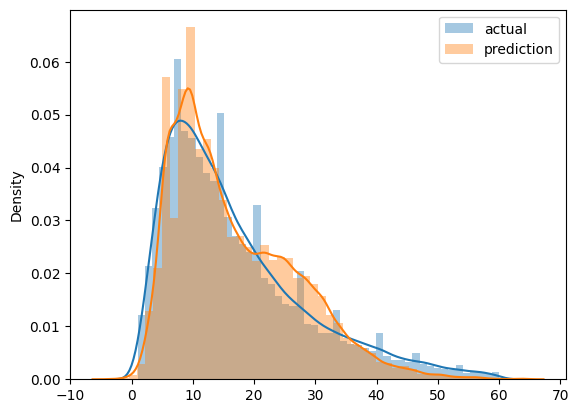

In [26]:
sns.distplot(y_train, label ='actual')
sns.distplot(y_pred, label ='prediction')
plt.legend()

In [33]:
mean_squared_error(y_train, y_pred, squared=False)

5.699564118199007

In [42]:
with mlflow.start_run():
    mlflow.set_tag("developer","ozge")
    
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    
    alpha =0.01
    mlflow.log_param("alpha", alpha)
    
    la = Lasso(alpha)
    la.fit(X_train,y_train)
    y_pred = la.predict(X_train)
    rmse= mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [29]:
import xgboost as xgb

In [30]:
from hyperopt import fmin, tpe ,hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [31]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


In [47]:
def objective (params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
    
        mlflow.log_params(params)
        
        booster = xgb.train(
        params= params,
        dtrain = train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )
        y_pred= booster.predict(valid)
        rmse= mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [48]:
search_space={
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # between exp(-3) and exp(0) [0.05 - 1]
    'reg_alpha': hp.loguniform('reg_alpha',-5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective':'reg:linear',
    'seed':42
}

In [49]:
best_result=fmin(
    fn=objective, 
    space = search_space, 
    algo=tpe.suggest, #algorithm used for optimization
    max_evals=50, 
    trials=Trials())

[22:45:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.                                          
[0]	validation-rmse:15.84632                                                                                                                                    
[1]	validation-rmse:12.32447                                                                                                                                    
[2]	validation-rmse:10.07333                                                                                                                                    
[3]	validation-rmse:8.68637                                                                                                                                     
[4]	validation-rmse:7.85393                                                                                                                                     
[5]	validation-rmse:7.36228       

[99]	validation-rmse:6.49841                                                                                                                                    
[100]	validation-rmse:6.49827                                                                                                                                   
[101]	validation-rmse:6.49845                                                                                                                                   
[102]	validation-rmse:6.49835                                                                                                                                   
[103]	validation-rmse:6.49801                                                                                                                                   
[104]	validation-rmse:6.49776                                                                                                                                   
[105]	validation-rmse:6.49759     

[199]	validation-rmse:6.49364                                                                                                                                   
[200]	validation-rmse:6.49382                                                                                                                                   
[201]	validation-rmse:6.49362                                                                                                                                   
[202]	validation-rmse:6.49359                                                                                                                                   
[203]	validation-rmse:6.49358                                                                                                                                   
[204]	validation-rmse:6.49343                                                                                                                                   
[205]	validation-rmse:6.49342     

[70]	validation-rmse:6.57733                                                                                                                                    
[71]	validation-rmse:6.57587                                                                                                                                    
[72]	validation-rmse:6.57444                                                                                                                                    
[73]	validation-rmse:6.57335                                                                                                                                    
[74]	validation-rmse:6.57213                                                                                                                                    
[75]	validation-rmse:6.57092                                                                                                                                    
[76]	validation-rmse:6.56944      

[170]	validation-rmse:6.51407                                                                                                                                   
[171]	validation-rmse:6.51365                                                                                                                                   
[172]	validation-rmse:6.51328                                                                                                                                   
[173]	validation-rmse:6.51278                                                                                                                                   
[174]	validation-rmse:6.51236                                                                                                                                   
[175]	validation-rmse:6.51181                                                                                                                                   
[176]	validation-rmse:6.51141     

[270]	validation-rmse:6.48174                                                                                                                                   
[271]	validation-rmse:6.48138                                                                                                                                   
[272]	validation-rmse:6.48095                                                                                                                                   
[273]	validation-rmse:6.48067                                                                                                                                   
[274]	validation-rmse:6.48034                                                                                                                                   
[275]	validation-rmse:6.48001                                                                                                                                   
[276]	validation-rmse:6.47979     

[370]	validation-rmse:6.45776                                                                                                                                   
[371]	validation-rmse:6.45759                                                                                                                                   
[372]	validation-rmse:6.45737                                                                                                                                   
[373]	validation-rmse:6.45709                                                                                                                                   
[374]	validation-rmse:6.45706                                                                                                                                   
[375]	validation-rmse:6.45685                                                                                                                                   
[376]	validation-rmse:6.45664     

[470]	validation-rmse:6.43947                                                                                                                                   
[471]	validation-rmse:6.43942                                                                                                                                   
[472]	validation-rmse:6.43934                                                                                                                                   
[473]	validation-rmse:6.43922                                                                                                                                   
[474]	validation-rmse:6.43912                                                                                                                                   
[475]	validation-rmse:6.43909                                                                                                                                   
[476]	validation-rmse:6.43894     

[570]	validation-rmse:6.42458                                                                                                                                   
[571]	validation-rmse:6.42445                                                                                                                                   
[572]	validation-rmse:6.42439                                                                                                                                   
[573]	validation-rmse:6.42419                                                                                                                                   
[574]	validation-rmse:6.42405                                                                                                                                   
[575]	validation-rmse:6.42393                                                                                                                                   
[576]	validation-rmse:6.42377     

[670]	validation-rmse:6.41171                                                                                                                                   
[671]	validation-rmse:6.41162                                                                                                                                   
[672]	validation-rmse:6.41149                                                                                                                                   
[673]	validation-rmse:6.41138                                                                                                                                   
[674]	validation-rmse:6.41123                                                                                                                                   
[675]	validation-rmse:6.41116                                                                                                                                   
[676]	validation-rmse:6.41108     

[770]	validation-rmse:6.40191                                                                                                                                   
[771]	validation-rmse:6.40178                                                                                                                                   
[772]	validation-rmse:6.40169                                                                                                                                   
[773]	validation-rmse:6.40160                                                                                                                                   
[774]	validation-rmse:6.40151                                                                                                                                   
[775]	validation-rmse:6.40140                                                                                                                                   
[776]	validation-rmse:6.40128     

[870]	validation-rmse:6.39315                                                                                                                                   
[871]	validation-rmse:6.39314                                                                                                                                   
[872]	validation-rmse:6.39309                                                                                                                                   
[873]	validation-rmse:6.39295                                                                                                                                   
[874]	validation-rmse:6.39286                                                                                                                                   
[875]	validation-rmse:6.39276                                                                                                                                   
[876]	validation-rmse:6.39265     

[970]	validation-rmse:6.38515                                                                                                                                   
[971]	validation-rmse:6.38511                                                                                                                                   
[972]	validation-rmse:6.38506                                                                                                                                   
[973]	validation-rmse:6.38498                                                                                                                                   
[974]	validation-rmse:6.38491                                                                                                                                   
[975]	validation-rmse:6.38485                                                                                                                                   
[976]	validation-rmse:6.38458     

[69]	validation-rmse:6.41049                                                                                                                                    
[70]	validation-rmse:6.41005                                                                                                                                    
[71]	validation-rmse:6.40984                                                                                                                                    
[72]	validation-rmse:6.40798                                                                                                                                    
[73]	validation-rmse:6.40876                                                                                                                                    
[74]	validation-rmse:6.40754                                                                                                                                    
[75]	validation-rmse:6.40741      

[169]	validation-rmse:6.34360                                                                                                                                   
[170]	validation-rmse:6.34081                                                                                                                                   
[171]	validation-rmse:6.33994                                                                                                                                   
[172]	validation-rmse:6.33926                                                                                                                                   
[173]	validation-rmse:6.33706                                                                                                                                   
[174]	validation-rmse:6.33677                                                                                                                                   
[175]	validation-rmse:6.33647     

[269]	validation-rmse:6.32197                                                                                                                                   
[270]	validation-rmse:6.32179                                                                                                                                   
[271]	validation-rmse:6.32153                                                                                                                                   
[272]	validation-rmse:6.32189                                                                                                                                   
[273]	validation-rmse:6.32123                                                                                                                                   
[274]	validation-rmse:6.32094                                                                                                                                   
[275]	validation-rmse:6.32076     

[42]	validation-rmse:6.51620                                                                                                                                    
[43]	validation-rmse:6.51430                                                                                                                                    
[44]	validation-rmse:6.51274                                                                                                                                    
[45]	validation-rmse:6.51080                                                                                                                                    
[46]	validation-rmse:6.50937                                                                                                                                    
[47]	validation-rmse:6.50817                                                                                                                                    
[48]	validation-rmse:6.50666      

[142]	validation-rmse:6.45790                                                                                                                                   
[143]	validation-rmse:6.45793                                                                                                                                   
[144]	validation-rmse:6.45727                                                                                                                                   
[145]	validation-rmse:6.45729                                                                                                                                   
[146]	validation-rmse:6.45651                                                                                                                                   
[147]	validation-rmse:6.45634                                                                                                                                   
[148]	validation-rmse:6.45597     

[242]	validation-rmse:6.44562                                                                                                                                   
[243]	validation-rmse:6.44518                                                                                                                                   
[244]	validation-rmse:6.44529                                                                                                                                   
[245]	validation-rmse:6.44546                                                                                                                                   
[246]	validation-rmse:6.44532                                                                                                                                   
[247]	validation-rmse:6.44533                                                                                                                                   
[248]	validation-rmse:6.44531     

[342]	validation-rmse:6.44120                                                                                                                                   
[343]	validation-rmse:6.44118                                                                                                                                   
[344]	validation-rmse:6.44115                                                                                                                                   
[345]	validation-rmse:6.44126                                                                                                                                   
[346]	validation-rmse:6.44176                                                                                                                                   
[347]	validation-rmse:6.44250                                                                                                                                   
[348]	validation-rmse:6.44267     

[47]	validation-rmse:6.54549                                                                                                                                    
[48]	validation-rmse:6.54460                                                                                                                                    
[49]	validation-rmse:6.54376                                                                                                                                    
[50]	validation-rmse:6.54253                                                                                                                                    
[51]	validation-rmse:6.54149                                                                                                                                    
[52]	validation-rmse:6.54112                                                                                                                                    
[53]	validation-rmse:6.54065      

[147]	validation-rmse:6.47657                                                                                                                                   
[148]	validation-rmse:6.47624                                                                                                                                   
[149]	validation-rmse:6.47516                                                                                                                                   
[150]	validation-rmse:6.47497                                                                                                                                   
[151]	validation-rmse:6.47493                                                                                                                                   
[152]	validation-rmse:6.47425                                                                                                                                   
[153]	validation-rmse:6.47427     

[247]	validation-rmse:6.44321                                                                                                                                   
[248]	validation-rmse:6.44324                                                                                                                                   
[249]	validation-rmse:6.44304                                                                                                                                   
[250]	validation-rmse:6.44306                                                                                                                                   
[251]	validation-rmse:6.44316                                                                                                                                   
[252]	validation-rmse:6.44302                                                                                                                                   
[253]	validation-rmse:6.44275     

[347]	validation-rmse:6.42398                                                                                                                                   
[348]	validation-rmse:6.42342                                                                                                                                   
[349]	validation-rmse:6.42310                                                                                                                                   
[350]	validation-rmse:6.42289                                                                                                                                   
[351]	validation-rmse:6.42284                                                                                                                                   
[352]	validation-rmse:6.42249                                                                                                                                   
[353]	validation-rmse:6.42219     

[447]	validation-rmse:6.40912                                                                                                                                   
[448]	validation-rmse:6.40919                                                                                                                                   
[449]	validation-rmse:6.40944                                                                                                                                   
[450]	validation-rmse:6.40913                                                                                                                                   
[451]	validation-rmse:6.40885                                                                                                                                   
[452]	validation-rmse:6.40879                                                                                                                                   
[453]	validation-rmse:6.40867     

[547]	validation-rmse:6.40140                                                                                                                                   
[548]	validation-rmse:6.40144                                                                                                                                   
[549]	validation-rmse:6.40124                                                                                                                                   
[550]	validation-rmse:6.40130                                                                                                                                   
[551]	validation-rmse:6.40152                                                                                                                                   
[552]	validation-rmse:6.40146                                                                                                                                   
[553]	validation-rmse:6.40137     

[647]	validation-rmse:6.39750                                                                                                                                   
[648]	validation-rmse:6.39749                                                                                                                                   
[649]	validation-rmse:6.39736                                                                                                                                   
[650]	validation-rmse:6.39711                                                                                                                                   
[651]	validation-rmse:6.39708                                                                                                                                   
[652]	validation-rmse:6.39708                                                                                                                                   
[653]	validation-rmse:6.39693     

[747]	validation-rmse:6.39565                                                                                                                                   
[748]	validation-rmse:6.39536                                                                                                                                   
[749]	validation-rmse:6.39536                                                                                                                                   
[750]	validation-rmse:6.39551                                                                                                                                   
[751]	validation-rmse:6.39545                                                                                                                                   
[752]	validation-rmse:6.39514                                                                                                                                   
[753]	validation-rmse:6.39516     

[11]	validation-rmse:6.74607                                                                                                                                    
[12]	validation-rmse:6.70794                                                                                                                                    
[13]	validation-rmse:6.68104                                                                                                                                    
[14]	validation-rmse:6.65958                                                                                                                                    
[15]	validation-rmse:6.64325                                                                                                                                    
[16]	validation-rmse:6.62933                                                                                                                                    
[17]	validation-rmse:6.61789      

[111]	validation-rmse:6.56160                                                                                                                                   
[112]	validation-rmse:6.56114                                                                                                                                   
[113]	validation-rmse:6.56164                                                                                                                                   
[114]	validation-rmse:6.56192                                                                                                                                   
[115]	validation-rmse:6.56221                                                                                                                                   
[116]	validation-rmse:6.56242                                                                                                                                   
[117]	validation-rmse:6.56360     

[83]	validation-rmse:6.41180                                                                                                                                    
[84]	validation-rmse:6.41170                                                                                                                                    
[85]	validation-rmse:6.41129                                                                                                                                    
[86]	validation-rmse:6.41089                                                                                                                                    
[87]	validation-rmse:6.41043                                                                                                                                    
[88]	validation-rmse:6.40980                                                                                                                                    
[89]	validation-rmse:6.40955      

[183]	validation-rmse:6.38840                                                                                                                                   
[184]	validation-rmse:6.38855                                                                                                                                   
[185]	validation-rmse:6.38903                                                                                                                                   
[186]	validation-rmse:6.38907                                                                                                                                   
[187]	validation-rmse:6.38912                                                                                                                                   
[188]	validation-rmse:6.38943                                                                                                                                   
[189]	validation-rmse:6.38956     

[48]	validation-rmse:6.66663                                                                                                                                    
[49]	validation-rmse:6.66643                                                                                                                                    
[50]	validation-rmse:6.66637                                                                                                                                    
[51]	validation-rmse:6.66566                                                                                                                                    
[52]	validation-rmse:6.66550                                                                                                                                    
[53]	validation-rmse:6.66563                                                                                                                                    
[54]	validation-rmse:6.66516      

[8]	validation-rmse:10.85437                                                                                                                                    
[9]	validation-rmse:10.28119                                                                                                                                    
[10]	validation-rmse:9.78072                                                                                                                                    
[11]	validation-rmse:9.34329                                                                                                                                    
[12]	validation-rmse:8.96671                                                                                                                                    
[13]	validation-rmse:8.64245                                                                                                                                    
[14]	validation-rmse:8.36288      

[108]	validation-rmse:6.49111                                                                                                                                   
[109]	validation-rmse:6.49047                                                                                                                                   
[110]	validation-rmse:6.48976                                                                                                                                   
[111]	validation-rmse:6.48946                                                                                                                                   
[112]	validation-rmse:6.48882                                                                                                                                   
[113]	validation-rmse:6.48825                                                                                                                                   
[114]	validation-rmse:6.48750     

[208]	validation-rmse:6.45216                                                                                                                                   
[209]	validation-rmse:6.45189                                                                                                                                   
[210]	validation-rmse:6.45150                                                                                                                                   
[211]	validation-rmse:6.45129                                                                                                                                   
[212]	validation-rmse:6.45108                                                                                                                                   
[213]	validation-rmse:6.45096                                                                                                                                   
[214]	validation-rmse:6.45064     

[308]	validation-rmse:6.42612                                                                                                                                   
[309]	validation-rmse:6.42599                                                                                                                                   
[310]	validation-rmse:6.42558                                                                                                                                   
[311]	validation-rmse:6.42543                                                                                                                                   
[312]	validation-rmse:6.42520                                                                                                                                   
[313]	validation-rmse:6.42490                                                                                                                                   
[314]	validation-rmse:6.42528     

[408]	validation-rmse:6.41005                                                                                                                                   
[409]	validation-rmse:6.41010                                                                                                                                   
[410]	validation-rmse:6.41013                                                                                                                                   
[411]	validation-rmse:6.40991                                                                                                                                   
[412]	validation-rmse:6.40947                                                                                                                                   
[413]	validation-rmse:6.40977                                                                                                                                   
[414]	validation-rmse:6.40980     

[508]	validation-rmse:6.39724                                                                                                                                   
[509]	validation-rmse:6.39717                                                                                                                                   
[510]	validation-rmse:6.39708                                                                                                                                   
[511]	validation-rmse:6.39705                                                                                                                                   
[512]	validation-rmse:6.39695                                                                                                                                   
[513]	validation-rmse:6.39682                                                                                                                                   
[514]	validation-rmse:6.39678     

[608]	validation-rmse:6.38818                                                                                                                                   
[609]	validation-rmse:6.38817                                                                                                                                   
[610]	validation-rmse:6.38815                                                                                                                                   
[611]	validation-rmse:6.38823                                                                                                                                   
[612]	validation-rmse:6.38798                                                                                                                                   
[613]	validation-rmse:6.38810                                                                                                                                   
[614]	validation-rmse:6.38813     

[708]	validation-rmse:6.38357                                                                                                                                   
[709]	validation-rmse:6.38346                                                                                                                                   
[710]	validation-rmse:6.38347                                                                                                                                   
[711]	validation-rmse:6.38340                                                                                                                                   
[712]	validation-rmse:6.38344                                                                                                                                   
[713]	validation-rmse:6.38324                                                                                                                                   
[714]	validation-rmse:6.38317     

[808]	validation-rmse:6.37983                                                                                                                                   
[809]	validation-rmse:6.37972                                                                                                                                   
[810]	validation-rmse:6.37962                                                                                                                                   
[811]	validation-rmse:6.37971                                                                                                                                   
[812]	validation-rmse:6.37977                                                                                                                                   
[813]	validation-rmse:6.37969                                                                                                                                   
[814]	validation-rmse:6.37960     

[908]	validation-rmse:6.37663                                                                                                                                   
[909]	validation-rmse:6.37650                                                                                                                                   
[910]	validation-rmse:6.37638                                                                                                                                   
[911]	validation-rmse:6.37636                                                                                                                                   
[912]	validation-rmse:6.37648                                                                                                                                   
[913]	validation-rmse:6.37634                                                                                                                                   
[914]	validation-rmse:6.37635     

[36]	validation-rmse:6.76856                                                                                                                                    
[37]	validation-rmse:6.74450                                                                                                                                    
[38]	validation-rmse:6.72289                                                                                                                                    
[39]	validation-rmse:6.70327                                                                                                                                    
[40]	validation-rmse:6.68493                                                                                                                                    
[41]	validation-rmse:6.66877                                                                                                                                    
[42]	validation-rmse:6.65432      

[136]	validation-rmse:6.46048                                                                                                                                   
[137]	validation-rmse:6.46020                                                                                                                                   
[138]	validation-rmse:6.45911                                                                                                                                   
[139]	validation-rmse:6.45869                                                                                                                                   
[140]	validation-rmse:6.45830                                                                                                                                   
[141]	validation-rmse:6.45783                                                                                                                                   
[142]	validation-rmse:6.45733     

[236]	validation-rmse:6.42182                                                                                                                                   
[237]	validation-rmse:6.42157                                                                                                                                   
[238]	validation-rmse:6.42125                                                                                                                                   
[239]	validation-rmse:6.42099                                                                                                                                   
[240]	validation-rmse:6.42074                                                                                                                                   
[241]	validation-rmse:6.42066                                                                                                                                   
[242]	validation-rmse:6.42031     

[336]	validation-rmse:6.39686                                                                                                                                   
[337]	validation-rmse:6.39658                                                                                                                                   
[338]	validation-rmse:6.39634                                                                                                                                   
[339]	validation-rmse:6.39619                                                                                                                                   
[340]	validation-rmse:6.39591                                                                                                                                   
[341]	validation-rmse:6.39567                                                                                                                                   
[342]	validation-rmse:6.39539     

[436]	validation-rmse:6.37834                                                                                                                                   
[437]	validation-rmse:6.37843                                                                                                                                   
[438]	validation-rmse:6.37837                                                                                                                                   
[439]	validation-rmse:6.37816                                                                                                                                   
[440]	validation-rmse:6.37814                                                                                                                                   
[441]	validation-rmse:6.37800                                                                                                                                   
[442]	validation-rmse:6.37777     

[536]	validation-rmse:6.36438                                                                                                                                   
[537]	validation-rmse:6.36429                                                                                                                                   
[538]	validation-rmse:6.36425                                                                                                                                   
[539]	validation-rmse:6.36416                                                                                                                                   
[540]	validation-rmse:6.36412                                                                                                                                   
[541]	validation-rmse:6.36390                                                                                                                                   
[542]	validation-rmse:6.36381     

[636]	validation-rmse:6.35389                                                                                                                                   
[637]	validation-rmse:6.35381                                                                                                                                   
[638]	validation-rmse:6.35375                                                                                                                                   
[639]	validation-rmse:6.35371                                                                                                                                   
[640]	validation-rmse:6.35358                                                                                                                                   
[641]	validation-rmse:6.35343                                                                                                                                   
[642]	validation-rmse:6.35321     

[736]	validation-rmse:6.34423                                                                                                                                   
[737]	validation-rmse:6.34414                                                                                                                                   
[738]	validation-rmse:6.34402                                                                                                                                   
[739]	validation-rmse:6.34390                                                                                                                                   
[740]	validation-rmse:6.34388                                                                                                                                   
[741]	validation-rmse:6.34385                                                                                                                                   
[742]	validation-rmse:6.34377     

[836]	validation-rmse:6.33745                                                                                                                                   
[837]	validation-rmse:6.33720                                                                                                                                   
[838]	validation-rmse:6.33721                                                                                                                                   
[839]	validation-rmse:6.33710                                                                                                                                   
[840]	validation-rmse:6.33721                                                                                                                                   
[841]	validation-rmse:6.33713                                                                                                                                   
[842]	validation-rmse:6.33717     

[936]	validation-rmse:6.33224                                                                                                                                   
[937]	validation-rmse:6.33215                                                                                                                                   
[938]	validation-rmse:6.33197                                                                                                                                   
[939]	validation-rmse:6.33193                                                                                                                                   
[940]	validation-rmse:6.33197                                                                                                                                   
[941]	validation-rmse:6.33183                                                                                                                                   
[942]	validation-rmse:6.33182     

[35]	validation-rmse:6.54735                                                                                                                                    
[36]	validation-rmse:6.54356                                                                                                                                    
[37]	validation-rmse:6.54004                                                                                                                                    
[38]	validation-rmse:6.53736                                                                                                                                    
[39]	validation-rmse:6.53431                                                                                                                                    
[40]	validation-rmse:6.53179                                                                                                                                    
[41]	validation-rmse:6.52973      

[135]	validation-rmse:6.44354                                                                                                                                   
[136]	validation-rmse:6.44271                                                                                                                                   
[137]	validation-rmse:6.44198                                                                                                                                   
[138]	validation-rmse:6.44162                                                                                                                                   
[139]	validation-rmse:6.44105                                                                                                                                   
[140]	validation-rmse:6.44048                                                                                                                                   
[141]	validation-rmse:6.44012     

[235]	validation-rmse:6.40066                                                                                                                                   
[236]	validation-rmse:6.40055                                                                                                                                   
[237]	validation-rmse:6.40008                                                                                                                                   
[238]	validation-rmse:6.39970                                                                                                                                   
[239]	validation-rmse:6.39946                                                                                                                                   
[240]	validation-rmse:6.39901                                                                                                                                   
[241]	validation-rmse:6.39870     

[335]	validation-rmse:6.37421                                                                                                                                   
[336]	validation-rmse:6.37390                                                                                                                                   
[337]	validation-rmse:6.37363                                                                                                                                   
[338]	validation-rmse:6.37339                                                                                                                                   
[339]	validation-rmse:6.37329                                                                                                                                   
[340]	validation-rmse:6.37313                                                                                                                                   
[341]	validation-rmse:6.37297     

[435]	validation-rmse:6.35522                                                                                                                                   
[436]	validation-rmse:6.35504                                                                                                                                   
[437]	validation-rmse:6.35496                                                                                                                                   
[438]	validation-rmse:6.35489                                                                                                                                   
[439]	validation-rmse:6.35467                                                                                                                                   
[440]	validation-rmse:6.35454                                                                                                                                   
[441]	validation-rmse:6.35413     

[535]	validation-rmse:6.34181                                                                                                                                   
[536]	validation-rmse:6.34165                                                                                                                                   
[537]	validation-rmse:6.34136                                                                                                                                   
[538]	validation-rmse:6.34145                                                                                                                                   
[539]	validation-rmse:6.34144                                                                                                                                   
[540]	validation-rmse:6.34136                                                                                                                                   
[541]	validation-rmse:6.34122     

[635]	validation-rmse:6.33251                                                                                                                                   
[636]	validation-rmse:6.33248                                                                                                                                   
[637]	validation-rmse:6.33246                                                                                                                                   
[638]	validation-rmse:6.33206                                                                                                                                   
[639]	validation-rmse:6.33198                                                                                                                                   
[640]	validation-rmse:6.33196                                                                                                                                   
[641]	validation-rmse:6.33186     

[735]	validation-rmse:6.32467                                                                                                                                   
[736]	validation-rmse:6.32461                                                                                                                                   
[737]	validation-rmse:6.32449                                                                                                                                   
[738]	validation-rmse:6.32423                                                                                                                                   
[739]	validation-rmse:6.32418                                                                                                                                   
[740]	validation-rmse:6.32427                                                                                                                                   
[741]	validation-rmse:6.32460     

[835]	validation-rmse:6.31870                                                                                                                                   
[836]	validation-rmse:6.31862                                                                                                                                   
[837]	validation-rmse:6.31872                                                                                                                                   
[838]	validation-rmse:6.31859                                                                                                                                   
[839]	validation-rmse:6.31870                                                                                                                                   
[840]	validation-rmse:6.31863                                                                                                                                   
[841]	validation-rmse:6.31865     

[935]	validation-rmse:6.31441                                                                                                                                   
[936]	validation-rmse:6.31443                                                                                                                                   
[937]	validation-rmse:6.31439                                                                                                                                   
[938]	validation-rmse:6.31433                                                                                                                                   
[939]	validation-rmse:6.31415                                                                                                                                   
[940]	validation-rmse:6.31397                                                                                                                                   
[941]	validation-rmse:6.31397     

[34]	validation-rmse:6.59025                                                                                                                                    
[35]	validation-rmse:6.58312                                                                                                                                    
[36]	validation-rmse:6.57721                                                                                                                                    
[37]	validation-rmse:6.57187                                                                                                                                    
[38]	validation-rmse:6.56745                                                                                                                                    
[39]	validation-rmse:6.56255                                                                                                                                    
[40]	validation-rmse:6.55836      

[134]	validation-rmse:6.48071                                                                                                                                   
[135]	validation-rmse:6.48050                                                                                                                                   
[136]	validation-rmse:6.47998                                                                                                                                   
[137]	validation-rmse:6.47968                                                                                                                                   
[138]	validation-rmse:6.47941                                                                                                                                   
[139]	validation-rmse:6.47929                                                                                                                                   
[140]	validation-rmse:6.47909     

[234]	validation-rmse:6.45494                                                                                                                                   
[235]	validation-rmse:6.45462                                                                                                                                   
[236]	validation-rmse:6.45420                                                                                                                                   
[237]	validation-rmse:6.45411                                                                                                                                   
[238]	validation-rmse:6.45401                                                                                                                                   
[239]	validation-rmse:6.45383                                                                                                                                   
[240]	validation-rmse:6.45363     

[334]	validation-rmse:6.43918                                                                                                                                   
[335]	validation-rmse:6.43907                                                                                                                                   
[336]	validation-rmse:6.43912                                                                                                                                   
[337]	validation-rmse:6.43909                                                                                                                                   
[338]	validation-rmse:6.43900                                                                                                                                   
[339]	validation-rmse:6.43893                                                                                                                                   
[340]	validation-rmse:6.43877     

[434]	validation-rmse:6.42887                                                                                                                                   
[435]	validation-rmse:6.42871                                                                                                                                   
[436]	validation-rmse:6.42855                                                                                                                                   
[437]	validation-rmse:6.42845                                                                                                                                   
[438]	validation-rmse:6.42844                                                                                                                                   
[439]	validation-rmse:6.42846                                                                                                                                   
[440]	validation-rmse:6.42825     

[534]	validation-rmse:6.42205                                                                                                                                   
[535]	validation-rmse:6.42206                                                                                                                                   
[536]	validation-rmse:6.42192                                                                                                                                   
[537]	validation-rmse:6.42195                                                                                                                                   
[538]	validation-rmse:6.42186                                                                                                                                   
[539]	validation-rmse:6.42187                                                                                                                                   
[540]	validation-rmse:6.42163     

[634]	validation-rmse:6.41930                                                                                                                                   
[635]	validation-rmse:6.41918                                                                                                                                   
[636]	validation-rmse:6.41917                                                                                                                                   
[637]	validation-rmse:6.41918                                                                                                                                   
[638]	validation-rmse:6.41916                                                                                                                                   
[639]	validation-rmse:6.41912                                                                                                                                   
[640]	validation-rmse:6.41904     

[734]	validation-rmse:6.41619                                                                                                                                   
[735]	validation-rmse:6.41620                                                                                                                                   
[736]	validation-rmse:6.41630                                                                                                                                   
[737]	validation-rmse:6.41622                                                                                                                                   
[738]	validation-rmse:6.41627                                                                                                                                   
[739]	validation-rmse:6.41629                                                                                                                                   
[740]	validation-rmse:6.41629     

[10]	validation-rmse:9.00698                                                                                                                                    
[11]	validation-rmse:8.61999                                                                                                                                    
[12]	validation-rmse:8.28995                                                                                                                                    
[13]	validation-rmse:8.01644                                                                                                                                    
[14]	validation-rmse:7.78746                                                                                                                                    
[15]	validation-rmse:7.59065                                                                                                                                    
[16]	validation-rmse:7.43218      

[110]	validation-rmse:6.46011                                                                                                                                   
[111]	validation-rmse:6.46010                                                                                                                                   
[112]	validation-rmse:6.45995                                                                                                                                   
[113]	validation-rmse:6.45927                                                                                                                                   
[114]	validation-rmse:6.45891                                                                                                                                   
[115]	validation-rmse:6.45827                                                                                                                                   
[116]	validation-rmse:6.45811     

[210]	validation-rmse:6.43445                                                                                                                                   
[211]	validation-rmse:6.43420                                                                                                                                   
[212]	validation-rmse:6.43402                                                                                                                                   
[213]	validation-rmse:6.43418                                                                                                                                   
[214]	validation-rmse:6.43456                                                                                                                                   
[215]	validation-rmse:6.43442                                                                                                                                   
[216]	validation-rmse:6.43427     

[310]	validation-rmse:6.42438                                                                                                                                   
[311]	validation-rmse:6.42429                                                                                                                                   
[312]	validation-rmse:6.42493                                                                                                                                   
[313]	validation-rmse:6.42483                                                                                                                                   
[314]	validation-rmse:6.42447                                                                                                                                   
[315]	validation-rmse:6.42444                                                                                                                                   
[316]	validation-rmse:6.42440     

[410]	validation-rmse:6.41919                                                                                                                                   
[411]	validation-rmse:6.41929                                                                                                                                   
[412]	validation-rmse:6.41926                                                                                                                                   
[413]	validation-rmse:6.41920                                                                                                                                   
[414]	validation-rmse:6.41918                                                                                                                                   
[415]	validation-rmse:6.41931                                                                                                                                   
[416]	validation-rmse:6.41930     

[510]	validation-rmse:6.41847                                                                                                                                   
[511]	validation-rmse:6.41846                                                                                                                                   
[512]	validation-rmse:6.41852                                                                                                                                   
[513]	validation-rmse:6.41875                                                                                                                                   
[514]	validation-rmse:6.41870                                                                                                                                   
[515]	validation-rmse:6.41865                                                                                                                                   
[516]	validation-rmse:6.41870     

[57]	validation-rmse:6.50802                                                                                                                                    
[58]	validation-rmse:6.50506                                                                                                                                    
[59]	validation-rmse:6.50302                                                                                                                                    
[60]	validation-rmse:6.50106                                                                                                                                    
[61]	validation-rmse:6.49882                                                                                                                                    
[62]	validation-rmse:6.49686                                                                                                                                    
[63]	validation-rmse:6.49479      

[157]	validation-rmse:6.43289                                                                                                                                   
[158]	validation-rmse:6.43260                                                                                                                                   
[159]	validation-rmse:6.43245                                                                                                                                   
[160]	validation-rmse:6.43209                                                                                                                                   
[161]	validation-rmse:6.43162                                                                                                                                   
[162]	validation-rmse:6.43138                                                                                                                                   
[163]	validation-rmse:6.43095     

[257]	validation-rmse:6.41022                                                                                                                                   
[258]	validation-rmse:6.40979                                                                                                                                   
[259]	validation-rmse:6.40943                                                                                                                                   
[260]	validation-rmse:6.40918                                                                                                                                   
[261]	validation-rmse:6.40884                                                                                                                                   
[262]	validation-rmse:6.40888                                                                                                                                   
[263]	validation-rmse:6.40865     

[357]	validation-rmse:6.39639                                                                                                                                   
[358]	validation-rmse:6.39642                                                                                                                                   
[359]	validation-rmse:6.39647                                                                                                                                   
[360]	validation-rmse:6.39653                                                                                                                                   
[361]	validation-rmse:6.39645                                                                                                                                   
[362]	validation-rmse:6.39634                                                                                                                                   
[363]	validation-rmse:6.39615     

[457]	validation-rmse:6.39010                                                                                                                                   
[458]	validation-rmse:6.39003                                                                                                                                   
[459]	validation-rmse:6.38998                                                                                                                                   
[460]	validation-rmse:6.38982                                                                                                                                   
[461]	validation-rmse:6.38983                                                                                                                                   
[462]	validation-rmse:6.38974                                                                                                                                   
[463]	validation-rmse:6.38974     

[557]	validation-rmse:6.38647                                                                                                                                   
[558]	validation-rmse:6.38633                                                                                                                                   
[559]	validation-rmse:6.38633                                                                                                                                   
[560]	validation-rmse:6.38634                                                                                                                                   
[561]	validation-rmse:6.38639                                                                                                                                   
[562]	validation-rmse:6.38626                                                                                                                                   
[563]	validation-rmse:6.38627     

[657]	validation-rmse:6.38402                                                                                                                                   
[658]	validation-rmse:6.38410                                                                                                                                   
[659]	validation-rmse:6.38407                                                                                                                                   
[660]	validation-rmse:6.38455                                                                                                                                   
[661]	validation-rmse:6.38489                                                                                                                                   
[662]	validation-rmse:6.38506                                                                                                                                   
[663]	validation-rmse:6.38517     

[49]	validation-rmse:6.69135                                                                                                                                    
[50]	validation-rmse:6.69105                                                                                                                                    
[51]	validation-rmse:6.69094                                                                                                                                    
[52]	validation-rmse:6.69065                                                                                                                                    
[53]	validation-rmse:6.69033                                                                                                                                    
[54]	validation-rmse:6.69034                                                                                                                                    
[55]	validation-rmse:6.68998      

[149]	validation-rmse:6.68321                                                                                                                                   
[150]	validation-rmse:6.68309                                                                                                                                   
[151]	validation-rmse:6.68301                                                                                                                                   
[152]	validation-rmse:6.68293                                                                                                                                   
[153]	validation-rmse:6.68315                                                                                                                                   
[154]	validation-rmse:6.68289                                                                                                                                   
[155]	validation-rmse:6.68300     

[1]	validation-rmse:18.50912                                                                                                                                    
[2]	validation-rmse:17.33799                                                                                                                                    
[3]	validation-rmse:16.27115                                                                                                                                    
[4]	validation-rmse:15.29982                                                                                                                                    
[5]	validation-rmse:14.41616                                                                                                                                    
[6]	validation-rmse:13.61275                                                                                                                                    
[7]	validation-rmse:12.88365      

[101]	validation-rmse:6.48721                                                                                                                                   
[102]	validation-rmse:6.48693                                                                                                                                   
[103]	validation-rmse:6.48628                                                                                                                                   
[104]	validation-rmse:6.48608                                                                                                                                   
[105]	validation-rmse:6.48545                                                                                                                                   
[106]	validation-rmse:6.48479                                                                                                                                   
[107]	validation-rmse:6.48433     

[201]	validation-rmse:6.46015                                                                                                                                   
[202]	validation-rmse:6.45992                                                                                                                                   
[203]	validation-rmse:6.45966                                                                                                                                   
[204]	validation-rmse:6.45939                                                                                                                                   
[205]	validation-rmse:6.45925                                                                                                                                   
[206]	validation-rmse:6.45895                                                                                                                                   
[207]	validation-rmse:6.45880     

[301]	validation-rmse:6.44893                                                                                                                                   
[302]	validation-rmse:6.44908                                                                                                                                   
[303]	validation-rmse:6.44892                                                                                                                                   
[304]	validation-rmse:6.44877                                                                                                                                   
[305]	validation-rmse:6.44874                                                                                                                                   
[306]	validation-rmse:6.44875                                                                                                                                   
[307]	validation-rmse:6.44868     

[401]	validation-rmse:6.44423                                                                                                                                   
[402]	validation-rmse:6.44408                                                                                                                                   
[403]	validation-rmse:6.44409                                                                                                                                   
[404]	validation-rmse:6.44403                                                                                                                                   
[405]	validation-rmse:6.44406                                                                                                                                   
[406]	validation-rmse:6.44398                                                                                                                                   
[407]	validation-rmse:6.44392     

[501]	validation-rmse:6.44229                                                                                                                                   
[502]	validation-rmse:6.44228                                                                                                                                   
[503]	validation-rmse:6.44229                                                                                                                                   
[504]	validation-rmse:6.44221                                                                                                                                   
[505]	validation-rmse:6.44217                                                                                                                                   
[506]	validation-rmse:6.44209                                                                                                                                   
[507]	validation-rmse:6.44212     

[29]	validation-rmse:7.63431                                                                                                                                    
[30]	validation-rmse:7.54764                                                                                                                                    
[31]	validation-rmse:7.46903                                                                                                                                    
[32]	validation-rmse:7.39704                                                                                                                                    
[33]	validation-rmse:7.33179                                                                                                                                    
[34]	validation-rmse:7.27223                                                                                                                                    
[35]	validation-rmse:7.21861      

[129]	validation-rmse:6.56984                                                                                                                                   
[130]	validation-rmse:6.56961                                                                                                                                   
[131]	validation-rmse:6.56924                                                                                                                                   
[132]	validation-rmse:6.56892                                                                                                                                   
[133]	validation-rmse:6.56859                                                                                                                                   
[134]	validation-rmse:6.56830                                                                                                                                   
[135]	validation-rmse:6.56805     

[229]	validation-rmse:6.55386                                                                                                                                   
[230]	validation-rmse:6.55384                                                                                                                                   
[231]	validation-rmse:6.55379                                                                                                                                   
[232]	validation-rmse:6.55358                                                                                                                                   
[233]	validation-rmse:6.55358                                                                                                                                   
[234]	validation-rmse:6.55351                                                                                                                                   
[235]	validation-rmse:6.55342     

In [54]:
best_params={
    'learning_rate': 0.5110880192015199,
'max_depth': 5,
'min_child_weight': 1.5901077448827408,
'objective': 'reg:linear',
'reg_alpha': 0.36616872953276464,
'reg_lambda': 0.008551346167686632,
'seed':42
}

In [55]:
with mlflow.start_run():
    mlflow.xgboost.autolog()
    booster = xgb.train(
            params= best_params,
            dtrain = train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
            )

In [36]:
with mlflow.start_run():
    mlflow.set_tag("save-model","log_model")
    best_params={
    'learning_rate': 0.5110880192015199,
    'max_depth': 5,
    'min_child_weight': 1.5901077448827408,
    'objective': 'reg:linear',
    'reg_alpha': 0.36616872953276464,
    'reg_lambda': 0.008551346167686632,
    'seed':42
    }
    mlflow.log_params(best_params)
    booster = xgb.train(
        params= best_params,
        dtrain = train,
        num_boost_round=500,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )
    y_pred= booster.predict(valid)
    rmse= mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    with open("/home/mlops_zoomcamp/notebooks/models/preprocessor.b","wb") as f_out:
        pickle.dump(dv,f_out)
    
    mlflow.log_artifact("/home/mlops_zoomcamp/notebooks/models/preprocessor.b", artifact_path= "preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")
    

[20:06:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.46798
[1]	validation-rmse:8.85106
[2]	validation-rmse:7.51797
[3]	validation-rmse:7.03738
[4]	validation-rmse:6.85688
[5]	validation-rmse:6.78229
[6]	validation-rmse:6.74274
[7]	validation-rmse:6.72394
[8]	validation-rmse:6.71456
[9]	validation-rmse:6.70626
[10]	validation-rmse:6.69940
[11]	validation-rmse:6.69615
[12]	validation-rmse:6.69264
[13]	validation-rmse:6.68976
[14]	validation-rmse:6.68763
[15]	validation-rmse:6.68273
[16]	validation-rmse:6.67834
[17]	validation-rmse:6.67726
[18]	validation-rmse:6.67428
[19]	validation-rmse:6.67261
[20]	validation-rmse:6.67018
[21]	validation-rmse:6.66978
[22]	validation-rmse:6.66664
[23]	validation-rmse:6.66560
[24]	validation-rmse:6.66389
[25]	validation-rmse:6.66318
[26]	validation-rmse:6.66036
[27]	validation-rmse:6.65884
[28]	validation-rmse:6.65515
[29]	validation-rmse:6.65400
[30]	validation-rmse

[273]	validation-rmse:6.44002
[274]	validation-rmse:6.44025
[275]	validation-rmse:6.43971
[276]	validation-rmse:6.43873
[277]	validation-rmse:6.43840
[278]	validation-rmse:6.43753
[279]	validation-rmse:6.43718
[280]	validation-rmse:6.43683
[281]	validation-rmse:6.43685
[282]	validation-rmse:6.43653
[283]	validation-rmse:6.43582
[284]	validation-rmse:6.43447
[285]	validation-rmse:6.43410
[286]	validation-rmse:6.43458
[287]	validation-rmse:6.43431
[288]	validation-rmse:6.43423
[289]	validation-rmse:6.43486
[290]	validation-rmse:6.43444
[291]	validation-rmse:6.43320
[292]	validation-rmse:6.43274
[293]	validation-rmse:6.43267
[294]	validation-rmse:6.43193
[295]	validation-rmse:6.42982
[296]	validation-rmse:6.42973
[297]	validation-rmse:6.42947
[298]	validation-rmse:6.42926
[299]	validation-rmse:6.42893
[300]	validation-rmse:6.42840
[301]	validation-rmse:6.42760
[302]	validation-rmse:6.42699
[303]	validation-rmse:6.42667
[304]	validation-rmse:6.42665
[305]	validation-rmse:6.42639
[306]	vali

In [37]:
import mlflow
logged_model = 'runs:/f840d8cdc2ca446f8b16c8a29be789b7/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



2023/05/29 20:15:00 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[20:15:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: f840d8cdc2ca446f8b16c8a29be789b7

In [39]:
xgboost_model = mlflow.xgboost.load_model('runs:/f840d8cdc2ca446f8b16c8a29be789b7/models_mlflow')

[20:16:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
xgboost_model

In [41]:
y_pred = xgboost_model.predict(valid)

In [42]:
y_pred[:10]

array([15.116232 ,  6.8490353, 17.131145 , 24.355621 ,  9.950941 ,
       17.16821  , 12.1764345,  9.556309 ,  8.881212 , 18.563673 ],
      dtype=float32)